# 2025-10-06 Low Rank

## Last time

* Solving least squares problems
* Geometry of the SVD

## Today

* Reflection on algorithm choices
* Low-rank structure
* Primer on interpolation

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2, aspect_ratio=:equal)
end

Aplot (generic function with 1 method)

# Condition number via SVD

$$ U \overbrace{\begin{bmatrix} \sigma_{\max} && \\ & \ddots & \\ && \sigma_{\min} \end{bmatrix}}^{\Sigma} V^T = A $$

\begin{align}
\lVert A \rVert &= \sigma_{\max} &
\kappa(A) &= \frac{\sigma_{\max}}{\sigma_{\min}} = \texttt{cond}(A)
\end{align}

In [36]:
A = randn(2,2) ## nonsymmetric
#A = A + A'

2×2 Matrix{Float64}:
 -0.7476    1.08969
  0.487512  1.0334

svdvals(A) = [1.5227644790588872, 0.8562092695757885]
norm(U - U') = 1.5700924586837752e-16


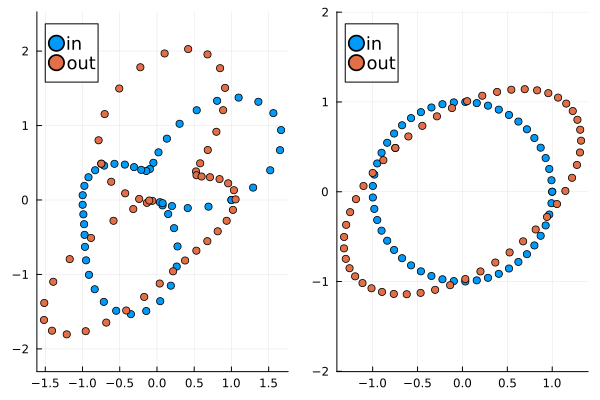

In [37]:
@show svdvals(A)
U, S, V = svd(A)
@show norm(U - U')
Aplot(A)

# Example: autonomous vehicles

* Need to solve least squares problems in real time
* Weight/cost/size increase with compute
* What algorithm to choose?
* What precision to use?

## Factors
* How many objects?
* Speed (of robot and objects)
* Aerial, wheeled, walking
* Fog, light -- longer memory?
* Tolerences (how accurate does the solution need to be?)
* Consequences of being wrong, who bears those consequences?

In [4]:
A = rand(5000, 500)
A_32 = Float32.(A)
@show cond(A)
@time qr(A);       # Householder; backward stable
@time qr_chol(A);  # Unstable
@time qr(A_32);

cond(A) = 56.40146543951136
  0.202298 seconds (42.99 k allocations: 21.522 MiB, 56.51% gc time, 13.47% compilation time)
  0.126691 seconds (271.75 k allocations: 37.191 MiB, 8.83% gc time, 64.42% compilation time)
  0.103200 seconds (110.47 k allocations: 15.324 MiB, 7.64% gc time, 42.06% compilation time)


In [5]:
V = vander(LinRange(-1, 1, 20))
@show cond(V)
Q, R = qr(Float32.(V))
@show norm(Q' * Q - I)
Q, R = qr_chol(V)
@show norm(Q' * Q - I)

cond(V) = 2.7224082312417406e8
norm(Q' * Q - I) = 1.6641898f-6
norm(Q' * Q - I) = 0.1749736012761826


0.1749736012761826

# Best low rank approximation

The SVD can be truncated to yield the best rank-$k$ approximation of a matrix.

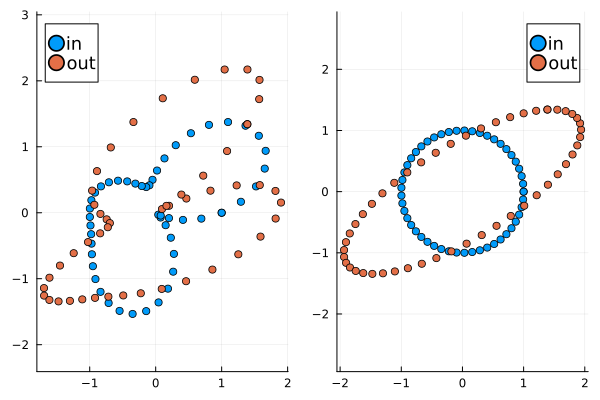

In [39]:
n, k = 2, 1
A = randn(n, n)
Aplot(A)

S[1:k + 1] = [2.230299652752217, 0.7704811470050307]
norm(Ahat) = 2.230299652752217


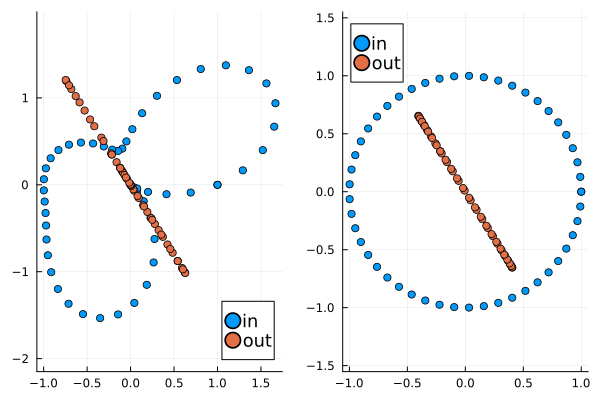

In [43]:
U, S, V = svd(A)
@show S[1:k+1]
Uhat = U[:, 1:k]
Shat = S[1:k]
Vhat = V[:, 1:k]
Ahat = Uhat * diagm(Shat) * Vhat'
@show norm(Ahat)
Aplot(A - Ahat)

# Example: Galaxies

Suppose we have two galaxies of size $n_1 = 100$ and $n_2 = 200$, each randomly distributed around their respective centers.

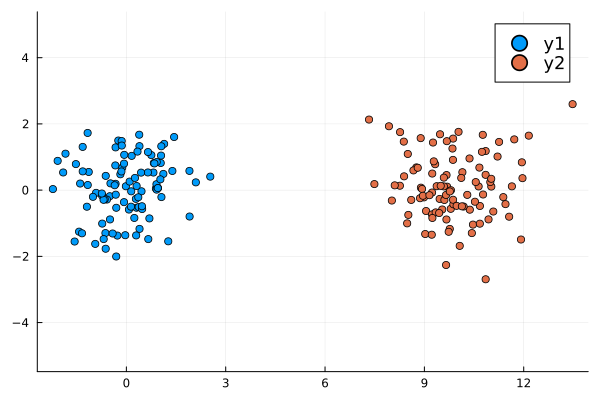

In [57]:
galaxy(center, sigma, n) = reshape(center, 1, 3) .+ sigma*randn(n, 3)
g1 = galaxy([0 0 0], 1, 100)
g2 = galaxy([10 0 0], 1, 100)

scatter(g1[:,1], g1[:,2], aspect_ratio=:equal)
scatter!(g2[:,1], g2[:,2])

## Forces between stars

Consider the gravitational force from a star at position $x_2$ acting on a star at position $x_1$,
$$ F_{1,2} = G \frac{m_1 m_2}{\lVert x_2 - x_1 \rVert^3} (x_2 - x_1) $$
where $m_1$ and $m_2$ are the masses of each star respectively.

In [47]:
function gravity(g1, g2)
    m = size(g1, 1)
    n = size(g2, 1)
    F = zeros(3*m, n)
    for i in 0:m-1
        for j in 1:n
            r = g2[j,:] - g1[1+i,:]
            F[1+3*i:3*(i+1),j] = r / norm(r)^3
        end
    end
    F
end
gravity(g1, g2)

300×100 Matrix{Float64}:
  0.0106383     0.00699245    0.00740756   …   0.00727092    0.00776894
  0.00146269   -2.39241e-5   -0.000206345     -0.00188306   -0.000283591
 -0.000963822   0.000284672  -0.000547106     -0.000633304  -0.000292133
  0.0153603     0.00956796    0.010052         0.00954714    0.0106886
  0.00237108   -0.000137105  -0.000436873     -0.00303367   -0.000577769
 -0.00247369    8.82342e-5   -0.00127273   …  -0.00138278   -0.00091052
  0.011718      0.00801123    0.00872117       0.00942179    0.00917859
  0.00386666    0.00107166    0.000976801     -0.00127195    0.000971326
 -0.000639344   0.000643732  -0.000377622     -0.000531795  -2.68599e-5
  0.0101141     0.0075187     0.00801389       0.00906729    0.00848553
  0.00414464    0.00150439    0.00145124   …  -0.000522076   0.00149879
 -0.00132426    0.000134957  -0.00084421      -0.00109643   -0.000570612
  0.0205216     0.0113415     0.0124251        0.0113496     0.0131232
  ⋮                                 

# Spectrum

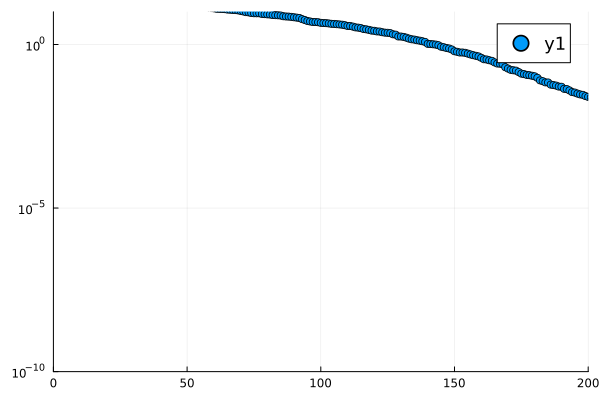

In [54]:
g1 = galaxy([0 0 0], 1, 500)
g2 = galaxy([3 0 0], 1, 500)
F = gravity(g1, g2)
U, S, V = svd(F)
scatter(S, yscale=:log10, ylims=(1e-10, 10), xlims=(0, 200))

In [56]:
k = 200
Uhat = U[:,1:k]
Shat = S[1:k]
Vhat = V[:,1:k]
Fhat = Uhat * diagm(Shat) * Vhat'
@show norm(F)
@show norm(F - Fhat)
size(F)

norm(F) = 259.6305281734927
norm(F - Fhat) = 0.06569130964932607


(1500, 500)